In [1]:
import importlib
import discovery as ds
import json
import numpy as np
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_enable_x64', True)

In [2]:
import discovery.samplers.numpyro as ds_numpyro
#import discovery.samplers.jaxns as ds_jaxns
import arviz as az

In [3]:
import mpi4py
from numpyro.contrib.nested_sampling import NestedSampler

INFO:2025-08-20 14:40:18,406:jax._src.xla_bridge:830: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [4]:
noisefile = "/home/mattm/projects/MPTA/MPTA_thirdpass_WN_initial_forDISCO.json"

In [5]:
noisedict = {}
if noisefile is not None:
    with open(noisefile, 'r') as fp:
        noisedict.update(json.load(fp))

In [6]:
from functools import partial

In [7]:
def generate_positive_normal(mean, std_dev, size):
    samples = np.empty(size)
    for i in range(size):
        while True:
            value = np.random.normal(mean, std_dev)
            if value >= 0:
                samples[i] = value
                break
    return samples

def generate_skewed_normal_chromaticity(mean, std_dev, size):
    samples = np.empty(size)
    for i in range(size):
        while True:
            value = np.random.normal(mean, std_dev)
            if value >= 2.5:
                samples[i] = value
                break
    return samples

In [8]:
psrs = [ds.Pulsar.read_feather(f) for f in glob.glob('/home/mattm/projects/MPTA/feather/*.feather')[:2]]

In [9]:
#ds.signals.make_fourierbasis_chrom_inj(chromaticity)

In [10]:
ds.signals.fourierbasis_dm

<function discovery.signals.fourierbasis_dm(psr, components, T=None, fref=1400.0)>

In [11]:

pslmodels = []
chrom_collector = []

fourdelay = ds.makefourier_binary(pulsarterm=True)
timedelay = ds.makedelay_binary(pulsarterm=False)
cwcommon = ['cw_sindec', 'cw_cosinc', 'cw_log10_f0', 'cw_log10_h0', 'cw_phi_earth', 'cw_psi', 'cw_ra']

for psr in psrs:
    chromaticity = generate_positive_normal(4,1,1)[0]
    chrom_collector.append(chromaticity)
    #chromaticity = 5
    fourierbasis_chrom_inject = partial(ds.signals.fourierbasis_chrom_inj, alpha=chromaticity)
    
    psr_tspan = ds.getspan(psr)
    pslmodels.append(ds.PulsarLikelihood([psr.residuals,
                                          ds.makenoise_measurement(psr, noisedict),
                                          ds.makegp_timing(psr, variance=1e-14),
                                          ds.makegp_fourier(psr, ds.powerlaw, 30, T=psr_tspan, name='rednoise'),
                                          #ds.makegp_fourier(psr, ds.powerlaw, components=30, T=psr_tspan, fourierbasis=ds.signals.fourierbasis_dm, name='dm_gp'),
                                          #ds.makegp_fourier(psr, ds.powerlaw, components=30, T=psr_tspan, fourierbasis=fourierbasis_chrom_inject, name='chrom_gp'),
                                          #ds.makedelay(psr, timedelay, common=cwcommon, name='cw')
                                         ]))


    

In [12]:
pslmodels[0].logL.params

['J1455-3330_rednoise_gamma', 'J1455-3330_rednoise_log10_A']

In [13]:
chrom_collector

[np.float64(3.865507010836052), np.float64(5.830113356903872)]

In [14]:
Tspan = ds.getspan(psrs)

# CURN
gbl = ds.GlobalLikelihood(pslmodels, ds.makegp_fourier_global(psrs, ds.powerlaw, ds.uncorrelated_orf, 14, T=Tspan, name='gw'))
# CURN work in progress
# gbl = ds.ArrayLikelihood(pslmodels,
#                          commongp = ds.makecommongp_fourier(psrs, ds.makepowerlaw_crn(14), 30, T=Tspan, common=['crn_log10_A', 'crn_gamma'], name='red_noise'))

# HD
#gbl = ds.GlobalLikelihood(pslmodels, ds.makegp_fourier_global(psrs, ds.powerlaw, ds.hd_orf, 14, T=Tspan, name='gw'))
## HD work in progress 
# gbl = ds.ArrayLikelihood(pslmodels,
#                          commongp = ds.makecommongp_fourier(psrs, ds.makepowerlaw_crn(14), 30, T=Tspan, name='red_noise'),
#                          globalgp = ds.makegp_fourier_global(psrs, ds.powerlaw, ds.hd_orf, 14, T=Tspan, name='gw'))

#CW signal injection, F or T?
#globalgp = ds.makeglobalgp_fourier(psrs, ds.powerlaw, ds.hd_orf, 14, T, means=fourdelay, common=cwcommon, name='gw', meansname='cw')

In [15]:
#Create achrom RN signals
noisedict_red = {p: np.random.uniform(-18,-11) for psl in pslmodels for p in psl.logL.params if 'rednoise_log10_A' in p}
noisedict_red.update({p: np.random.uniform(1,7) for psl in pslmodels for p in psl.logL.params if 'rednoise_gamma' in p})

#Create DM noise signals (using Kolmogorov turb as a base)
noisedict_red.update({p: np.random.uniform(-18,-11) for psl in pslmodels for p in psl.logL.params if 'dm_gp_log10_A' in p})
noisedict_red.update({p: generate_positive_normal(8/3,1,1)[0] for psl in pslmodels for p in psl.logL.params if 'dm_gp_gamma' in p})

#Create scattering noise signals (assuming physical scattering indices)
noisedict_red.update({p: np.random.uniform(-18,-11) for psl in pslmodels for p in psl.logL.params if 'chrom_gp_log10_A' in p})
noisedict_red.update({p: np.random.uniform(1,7) for psl in pslmodels for p in psl.logL.params if 'chrom_gp_gamma' in p})

## For now I'm directly injecting the chromaticity through a work around as make_sample doesn't exist in all the right places yet. ##
## TODO: Write the make_sample function for 'WoodburyKernel_varNP' object has no attribute 'make_sample' & 'WoodburyKernel_varFP' object has no attribute 'make_sample'. 
## Appears to be connected to the code through self.N.make_sample() 

#noisedict_red.update({p: generate_positive_normal(4,1,1)[0] for psl in pslmodels for p in psl.logL.params if 'chrom_gp_alpha' in p})

In [16]:
dm_dist = generate_positive_normal(8/3,1,size=10000)
dm_dist_wider = generate_positive_normal(8/3,1.5,size=10000)

(array([234., 353., 430., 589., 685., 831., 877., 928., 923., 871., 812.,
        651., 522., 421., 304., 197., 162.,  90.,  52.,  44.,  13.,   5.,
          3.,   2.,   1.]),
 array([2.20321977e-03, 3.41146294e-01, 6.80089368e-01, 1.01903244e+00,
        1.35797552e+00, 1.69691859e+00, 2.03586166e+00, 2.37480474e+00,
        2.71374781e+00, 3.05269089e+00, 3.39163396e+00, 3.73057703e+00,
        4.06952011e+00, 4.40846318e+00, 4.74740626e+00, 5.08634933e+00,
        5.42529240e+00, 5.76423548e+00, 6.10317855e+00, 6.44212163e+00,
        6.78106470e+00, 7.12000778e+00, 7.45895085e+00, 7.79789392e+00,
        8.13683700e+00, 8.47578007e+00]),
 <BarContainer object of 25 artists>)

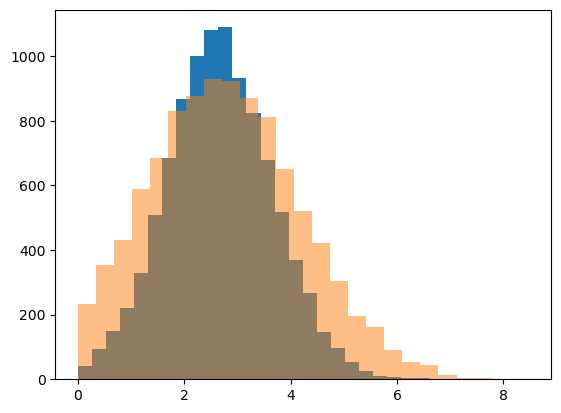

In [17]:
plt.hist(dm_dist,bins=25)
plt.hist(dm_dist_wider, bins=25, alpha=0.5)

(array([634., 792., 890., 911., 984., 986., 901., 760., 755., 620., 539.,
        396., 298., 198., 148.,  82.,  47.,  33.,   8.,   9.,   4.,   1.,
          2.,   1.,   1.]),
 array([ 2.50040595,  2.8116239 ,  3.12284184,  3.43405978,  3.74527772,
         4.05649566,  4.3677136 ,  4.67893155,  4.99014949,  5.30136743,
         5.61258537,  5.92380331,  6.23502125,  6.5462392 ,  6.85745714,
         7.16867508,  7.47989302,  7.79111096,  8.1023289 ,  8.41354685,
         8.72476479,  9.03598273,  9.34720067,  9.65841861,  9.96963655,
        10.2808545 ]),
 <BarContainer object of 25 artists>)

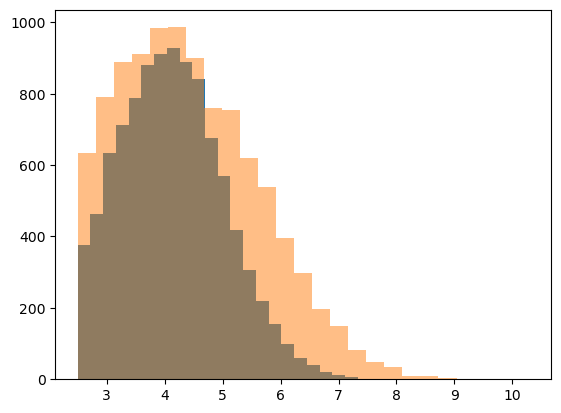

In [18]:
chromaticity_dist = generate_skewed_normal_chromaticity(4,1,size=10000)
chromaticity_dist_wider = generate_skewed_normal_chromaticity(4,1.5,size=10000)
plt.hist(chromaticity_dist,bins=25)
plt.hist(chromaticity_dist_wider, bins=25, alpha=0.5)

In [19]:
noisedict_red

{'J1455-3330_rednoise_log10_A': -14.522725191409956,
 'J1101-6424_rednoise_log10_A': -14.222860590773188,
 'J1455-3330_rednoise_gamma': 4.4658348343105505,
 'J1101-6424_rednoise_gamma': 6.5697312025256736}

In [20]:
gbl.logL.params

['J1101-6424_rednoise_gamma',
 'J1101-6424_rednoise_log10_A',
 'J1455-3330_rednoise_gamma',
 'J1455-3330_rednoise_log10_A',
 'gw_gamma',
 'gw_log10_A']

In [21]:
p0 = ds.sample_uniform(gbl.logL.params)

In [22]:
gbl.logL(p0)

Array(156460.52672225, dtype=float64)

In [23]:
p0

{'J1101-6424_rednoise_gamma': 0.7329213078899078,
 'J1101-6424_rednoise_log10_A': -11.218637393928711,
 'J1455-3330_rednoise_gamma': 5.516658646991505,
 'J1455-3330_rednoise_log10_A': -16.710288008204444,
 'gw_gamma': 2.842223012979279,
 'gw_log10_A': -13.881261689226525}

In [24]:
#plt.plot(psrs[0].toas, ds.makedelay(psrs[0], timedelay, name='cw', common=cwcommon)(p0))

KeyError: 'cw_log10_h0'

In [25]:
sampler = gbl.sample

In [26]:
#noisedict_red = {p: v for psr in psrs for p,v in noisedict.items() if 'rednoise' in p}
# params = {**ds.sample_uniform(sampler.params), **noisedict_red, 'gw_gamma': 4.333, 'gw_log10_A': -14.5, 
#           'cw_cosinc': 0.0, 'cw_log10_f0': 2e-8, 'cw_log10_h0': -15, 'cw_phi_earth': 5, 'cw_psi': np.pi/4.0, 'cw_ra': 0.458, 'cw_sindec': -0.43}

params = {**ds.sample_uniform(sampler.params), **noisedict_red, 'gw_gamma': 4.333, 'gw_log10_A': -14.5}


key = ds.rngkey(43)
key, res = sampler(key, params)

In [27]:
params

{'J1101-6424_rednoise_gamma': 6.5697312025256736,
 'J1101-6424_rednoise_log10_A': -14.222860590773188,
 'J1455-3330_rednoise_gamma': 4.4658348343105505,
 'J1455-3330_rednoise_log10_A': -14.522725191409956,
 'gw_log10_A': -14.5,
 'gw_gamma': 4.333,
 'cw_cosinc': 0.0,
 'cw_log10_f0': 2e-08,
 'cw_log10_h0': -15,
 'cw_phi_earth': 5,
 'cw_psi': 0.7853981633974483,
 'cw_ra': 0.458,
 'cw_sindec': -0.43}

In [28]:
res[1]*1e6 #change to microseconds

Array([  6.92665763,  -3.98417466, -18.9259047 , ...,  -2.56518606,
       -16.33207398,  -1.15993858], dtype=float64)

In [29]:
psrs[1].toas/86400 #change to days

array([58575.99458704, 58575.99458757, 58575.99458822, ...,
       60836.72094246, 60836.72094257, 60836.72094269], shape=(5969,))

In [30]:
psrs[1].toaerrs*1e6 #change to microseconds

array([9.705, 8.364, 7.91 , ..., 7.11 , 7.349, 7.562], shape=(5969,))

### What units are the feather pulsars in??

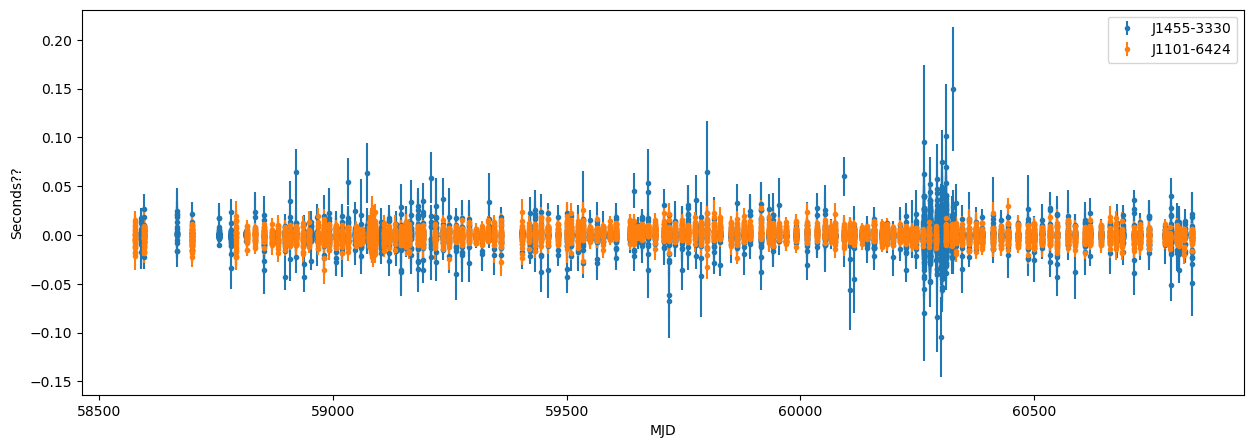

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))

for i, resids in enumerate(res):

    plt.errorbar(psrs[i].toas/86400, resids*1e3, yerr=psrs[i].toaerrs*1e3, marker=".",linestyle="",label=psrs[i].name) #toaerrs I think should actually be *1e6

    plt.ylabel("Seconds??")
    plt.xlabel("MJD")

plt.legend()

In [32]:
psrs[i].toaerrs

array([9.705e-06, 8.364e-06, 7.910e-06, ..., 7.110e-06, 7.349e-06,
       7.562e-06], shape=(5969,))

## Trial disco recovery runs

I still need to create a dummy feather pulsar with the injected values and then recreate the likelihood so that I can effectively sample the chromaticity. 

**This will not work properly until I can do that**

In [33]:
logl = gbl.logL

In [34]:
logp = ds.makelogprior_uniform(logl.params)

In [35]:
p0 = ds.sample_uniform(logl.params)
logl(p0)
jax.jit(logl)(p0)
jax.grad(logl)(p0)

{'J1101-6424_rednoise_gamma': Array(-1.51303071e-14, dtype=float64, weak_type=True),
 'J1101-6424_rednoise_log10_A': Array(-4.09272277e-13, dtype=float64, weak_type=True),
 'J1455-3330_rednoise_gamma': Array(0.00022758, dtype=float64, weak_type=True),
 'J1455-3330_rednoise_log10_A': Array(-0.00088769, dtype=float64, weak_type=True),
 'gw_gamma': Array(-1.53241344, dtype=float64, weak_type=True),
 'gw_log10_A': Array(-122.24832804, dtype=float64, weak_type=True)}

### HMC NUTS sampler

In [36]:
npmodel = ds_numpyro.makemodel_transformed(logl)
npsampler = ds_numpyro.makesampler_nuts(npmodel, num_samples=500)

In [37]:
#npsampler.run(jax.random.PRNGKey(42))

### NS sampler

In [38]:
ns = NestedSampler(npmodel, constructor_kwargs={'num_live_points':100})

In [ ]:
ns.run(jax.random.PRNGKey(2))

INFO:jaxns:Number of Markov-chains set to: 100


In [100]:
chain = npsampler.to_df()

In [101]:
chain

J1101-6424_chrom_gp_gamma  J1101-6424_chrom_gp_log10_A  \
0                    1.616486                   -19.670086   
1                    3.353926                   -16.596160   
2                    5.205897                   -14.436915   
3                    5.713824                   -18.619730   
4                    2.163215                   -19.242897   
..                        ...                          ...   
95                   1.653402                   -14.612506   
96                   3.525595                   -14.905626   
97                   3.705665                   -16.011633   
98                   3.404772                   -15.916641   
99                   4.664811                   -16.090442   

    J1101-6424_dm_gp_gamma  J1101-6424_dm_gp_log10_A  \
0                 3.942776                -12.715433   
1                 1.839240                -12.700720   
2                 3.347483                -12.542550   
3                 3.359671                -12.685067   
4                 1.950827                -12.613198   
..                     ...                       ...   
95                3.287017                -12.593801   
96                2.481091                -12.608871   
97                1.866826                -12.700643   
98                2.665625                -12.653310   
99                2.648584                -12.594578   

    J1101-6424_rednoise_gamma  J1101-6424_rednoise_log10_A  \
0                    2.543070                   -12.575019   
1                    1.652424                   -12.949991   
2                    2.414155                   -12.747193   
3                    1.338659                   -12.862383   
4                    0.893688                   -12.961574   
..                        ...                          ...   
95                   4.528651                   -14.536898   
96                   2.810463                   -16.720156   
97                   3.060247                   -15.836751   
98                   4.204844                   -18.260296   
99                   1.086509                   -12.870878   

    J1327-0755_chrom_gp_gamma  J1327-0755_chrom_gp_log10_A  \
0                    6.940122                   -17.211349   
1                    6.949041                   -16.974816   
2                    0.416318                   -15.754251   
3                    3.227847                   -15.088921   
4                    1.631479                   -19.341016   
..                        ...                          ...   
95                   4.884248                   -16.943688   
96                   4.324570                   -15.744785   
97                   1.339457                   -17.670556   
98                   6.070737                   -19.173550   
99                   0.589447                   -15.517158   

    J1327-0755_dm_gp_gamma  J1327-0755_dm_gp_log10_A  ...  \
0                 0.023481                -13.337469  ...   
1                 0.104185                -13.299987  ...   
2                 0.022355                -13.369079  ...   
3                 0.388529                -13.268585  ...   
4                 0.313743                -13.310507  ...   
..                     ...                       ...  ...   
95                0.150182                -13.358615  ...   
96                0.129818                -13.306011  ...   
97                0.109677                -13.286637  ...   
98                0.074239                -13.441830  ...   
99                0.031511                -13.442510  ...   

    J1902-5105_rednoise_gamma  J1902-5105_rednoise_log10_A  \
0                    1.009219                   -13.101394   
1                    0.883377                   -13.026395   
2                    0.980242                   -13.155158   
3                    1.112812                   -13.004217   
4                    0.891779                   -13.0

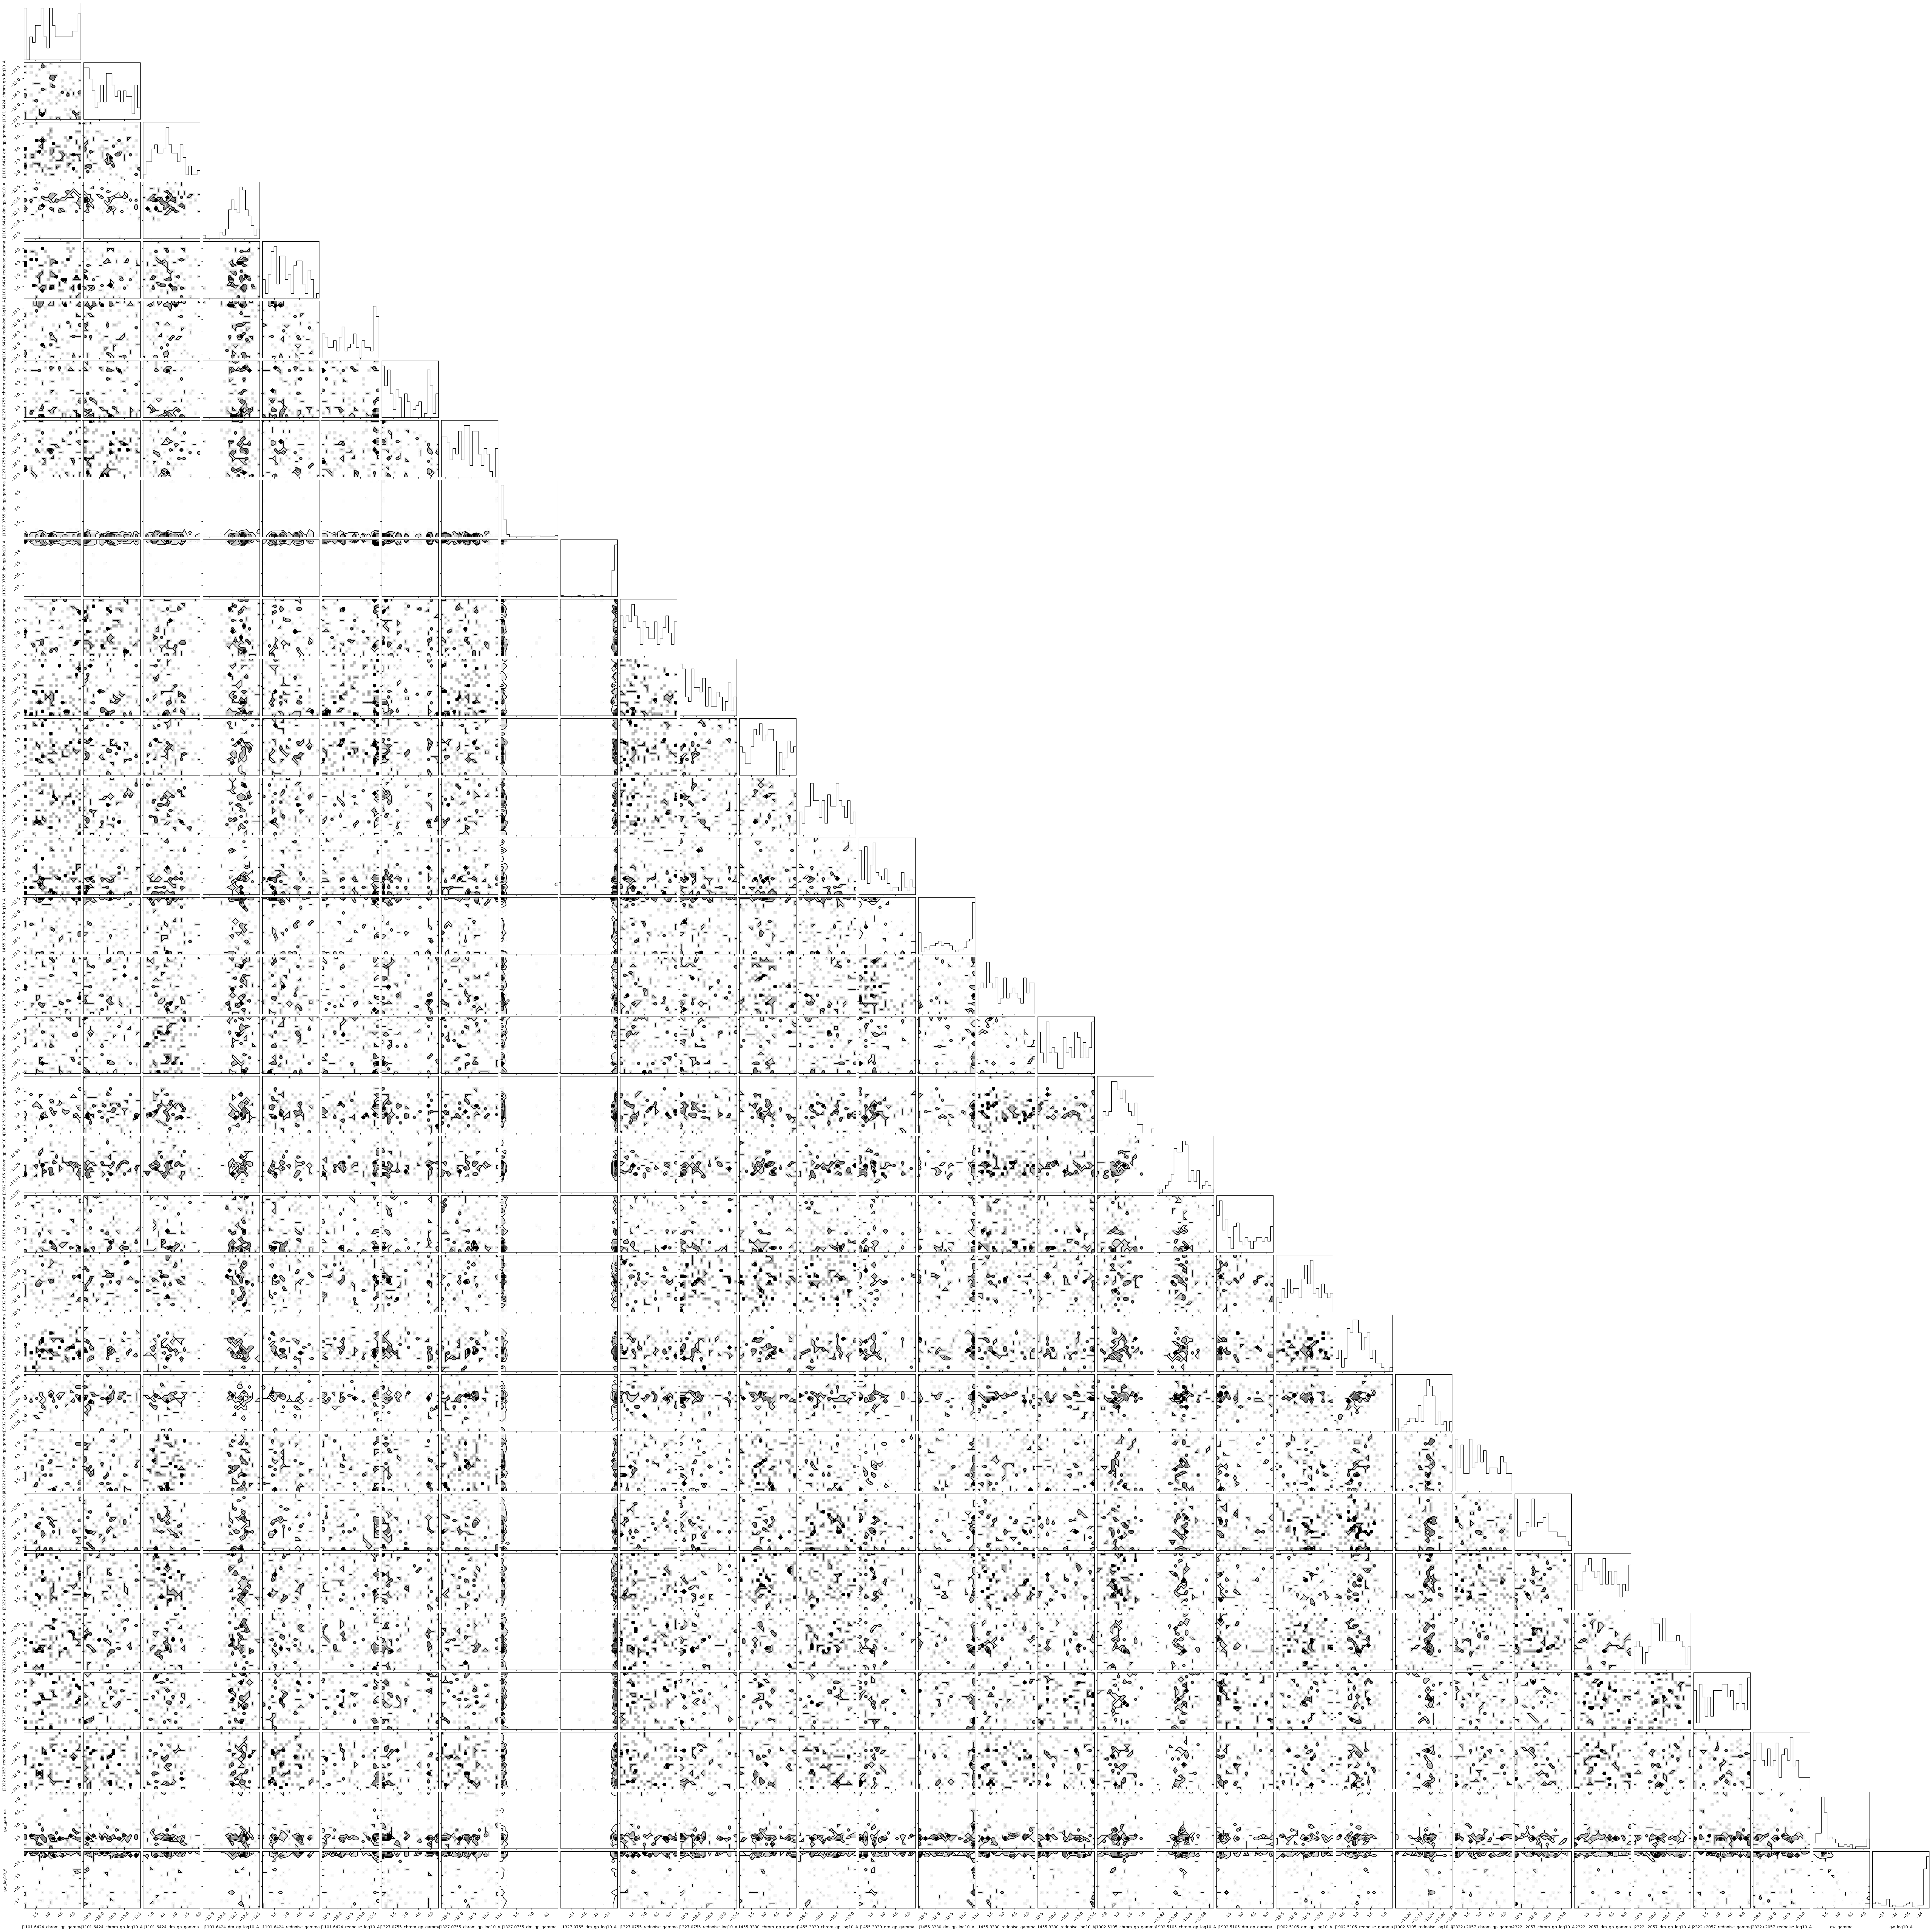

In [103]:
import corner

corner.corner(chain, labels=logl.params);

In [112]:
npsampler.post_warmup_state = npsampler.last_state

In [117]:
npsampler.num_samples = 500

In [118]:
npsampler.run(jax.random.PRNGKey(42))

sample: 100%|█| 500/500 [10:49<00:00,  1.30s/it, 63 steps of


In [109]:
chain2 = new_sampler.to_df()

In [111]:
chain2

J1101-6424_chrom_gp_gamma  J1101-6424_chrom_gp_log10_A  \
0                     6.673753                   -18.369675   
1                     6.673753                   -18.369675   
2                     6.673753                   -18.369675   
3                     6.673753                   -18.369675   
4                     6.673753                   -18.369675   
..                         ...                          ...   
495                   6.673753                   -18.369675   
496                   6.673753                   -18.369675   
497                   6.673753                   -18.369675   
498                   6.673753                   -18.369675   
499                   6.673753                   -18.369675   

     J1101-6424_dm_gp_gamma  J1101-6424_dm_gp_log10_A  \
0                  6.608637                -14.177222   
1                  6.608637                -14.177222   
2                  6.608637                -14.177222   
3                  6.608637                -14.177222   
4                  6.608637                -14.177222   
..                      ...                       ...   
495                6.608637                -14.177222   
496                6.608637                -14.177222   
497                6.608637                -14.177222   
498                6.608637                -14.177222   
499                6.608637                -14.177222   

     J1101-6424_rednoise_gamma  J1101-6424_rednoise_log10_A  \
0                     6.848176                   -19.719392   
1                     6.848176                   -19.719392   
2                     6.848176                   -19.719392   
3                     6.848176                   -19.719392   
4                     6.848176                   -19.719392   
..                         ...                          ...   
495                   6.848176                   -19.719392   
496                   6.848176                   -19.719392   
497                   6.848176                   -19.719392   
498                   6.848176                   -19.719392   
499                   6.848176                   -19.719392   

     J1327-0755_chrom_gp_gamma  J1327-0755_chrom_gp_log10_A  \
0                     6.411679                   -11.225877   
1                     6.411679                   -11.225877   
2                     6.411679                   -11.225877   
3                     6.411679                   -11.225877   
4                     6.411679                   -11.225877   
..                         ...                          ...   
495                   6.411679                   -11.225877   
496                   6.411679                   -11.225877   
497                   6.411679                   -11.225877   
498                   6.411679                   -11.225877   
499                   6.411679                   -11.225877   

     J1327-0755_dm_gp_gamma  J1327-0755_dm_gp_log10_A  ...  \
0                   5.67783                -11.376856  ...   
1                   5.67783                -11.376856  ...   
2                   5.67783                -11.376856  ...   
3                   5.67783                -11.376856  ...   
4                   5.67783                -11.376856  ...   
..                      ...                       ...  ...   
495                 5.67783                -11.376856  ...   
496                 5.67783                -11.376856  ...   
497                 5.67783                -11.376856  ...   
498                 5.67783                -11.376856  ...   
499                 5.67783                -11.376856  ...   

     J1902-5105_rednoise_gamma  J1902-5105_rednoise_log10_A  \
0                     0.565451                   -11.604723   
1                     0.565451                   -11.604723   
2                     0.565451                   -11.604723   
3                     0.565451                   -11